#  Example: Parallel tempering for multimodal distributions

Adapted from the TALENT course on Learning from Data: Bayesian Methods and Machine Learning, held in York, UK, June 10-28, 2019.
The original notebook was by Christian Forssen.  Revisions are by Dick Furnstahl for Physics 8805/8820.

**NOTE: This version of the notebook uses the [ptemcee](https://github.com/willvousden/ptemcee) sampler that was forked from emcee when version 3 was released.**

## Python imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;  sns.set(context='talk')

import emcee
import ptemcee
import corner

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

### Prior
Use a Gaussian prior centered at (0,0) with variance 10. So this is supposed to encompass the entire region where we expect significant posterior probability. In particular, in the example, it will include both Gaussian peaks. $\theta_0$ and $\theta_1$ are assumed to be uncorrelated.

In [2]:
mup = np.zeros(2)   # means
sigp=np.sqrt(10.)   # standard deviation
sigmap = np.diag([sigp**2, sigp**2]) # uncorrelated, so diagonal
sigmapinv = np.linalg.inv(sigmap)

# Normalization factor for the Gaussian
normp = 1/np.sqrt(np.linalg.det(2*np.pi*sigmap))

In [3]:
def log_prior(x):
    """
    Define the log prior using linear algebra, normp and sigmapinv defined globally.
    """ 
    dxp = x - mup
    return -dxp @ sigmapinv @ dxp /2 + np.log(normp)

### Likelihood

In [4]:
def setup_modes(sig=0.2, ratio=3.):
    """
    Set up two Gaussians for the likelihood
    """
    # Means of the two Gaussian modes
    mu1 = np.ones(2)
    mu2 = -np.ones(2)
    mu3 = np.array([0.5 -0.5])

    # Width in each dimension (zero correlation)
    _sig = sig
    sigma1 = np.diag([_sig**2, _sig**2])
    sigma2 = np.diag([_sig**2, _sig**2])
    sigma3 = 0.5 * np.diag([_sig**2, _sig**2])
    sigma1inv = np.linalg.inv(sigma1)
    sigma2inv = np.linalg.inv(sigma2)
    sigma3inv = np.linalg.inv(sigma3)

    # amplitudes of the two modes and the corresponding norm factor
    _amp1 = ratio / (1+ratio)
    _amp2 = 1. / (1+ratio)
    _amp3 = 1. 
    norm1 = _amp1 / np.sqrt(np.linalg.det(2*np.pi*sigma1))
    norm2 = _amp2 / np.sqrt(np.linalg.det(2*np.pi*sigma2))
    norm3 = _amp3 / np.sqrt(np.linalg.det(2*np.pi*sigma3))
    return (mu1,mu2,mu3,sigma1inv,sigma2inv,sigma3inv,norm1,norm2,norm3)

In [9]:
params_modes = setup_modes()  # use the defaults

# Define the log likelihood function
def log_likelihood(x, params=params_modes):
    """
    Define the log likelihoo function using linear algebra.
    """
    (mu1,mu2,mu3,sigma1inv,sigma2inv,sigma3inv,norm1,norm2,norm3) = params # split out the parameters
    dx1 = x - mu1
    dx2 = x - mu2
    dx3 = x - mu3
    return np.logaddexp( np.logaddexp(-dx1 @ sigma1inv @ dx1 / 2 + np.log(norm1), \
                        -dx2 @ sigma2inv @ dx2 / 2 + np.log(norm2)), \
                        -dx3 @ sigma3inv @ dx3 / 2 + np.log(norm3) )


### Posterior 

In [10]:
def log_posterior(x):
    """
    Return the log of the posterior, calling the log prior and log likelihood 
    functions.
    """
    return log_prior(x) + log_likelihood(x)

@np.vectorize
def posterior(y,x):
    """
    Return the posterior by exponentiating the log prior and likelihood.
    """
    xv=np.array([x,y])
    return np.exp(log_likelihood(xv) + log_prior(xv))

## MH Sampling and convergence

First do some basic sampling using the Metropolis-Hastings (MH) option in `emcee`. This is specified by `moves=emcee.moves.GaussianMove(cov)`. The starting positions are randomly distributed from 0 to 1 (not negative).

In [11]:
print('emcee sampling (version: )', emcee.__version__)

ndim = 2  # number of parameters in the model
nwalkers = 50
nwarmup = 1000
nsteps = 1000

# MH-Sampler setup
stepsize = .05
cov = stepsize * np.eye(ndim)
p0 = np.random.rand(nwalkers, ndim)   # uniform between 0 and 1

# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                               moves=emcee.moves.GaussianMove(cov))

emcee sampling (version: ) 3.1.0


Performing 1000 warmup iterations.
MH sampler performing 1000 samples.
CPU times: user 1.76 s, sys: 13.8 ms, total: 1.78 s
Wall time: 1.79 s
done
Mean acceptance fraction: 0.455


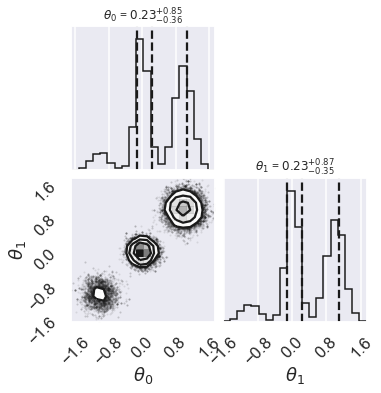

In [12]:
# Sample the posterior distribution

# Warm-up
if nwarmup > 0:
    print(f'Performing {nwarmup} warmup iterations.')
    pos, prob, state = sampler.run_mcmc(p0, nwarmup)
    sampler.reset()
else:
    pos = p0
    
# Perform iterations, starting at the final position from the warmup.
print(f'MH sampler performing {nsteps} samples.')
%time sampler.run_mcmc(pos, nsteps)
print("done")

print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

samples = sampler.chain.reshape((-1, ndim))
samples_unflattened = sampler.chain
lnposts = sampler.lnprobability.flatten()

    
# make a corner plot with the posterior distribution
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels=[r"$\theta_0$", r"$\theta_1$"],
                       show_titles=True, title_kwargs={"fontsize": 12})

**Question:** *According to this MCMC sampling, what does the posterior look like?*

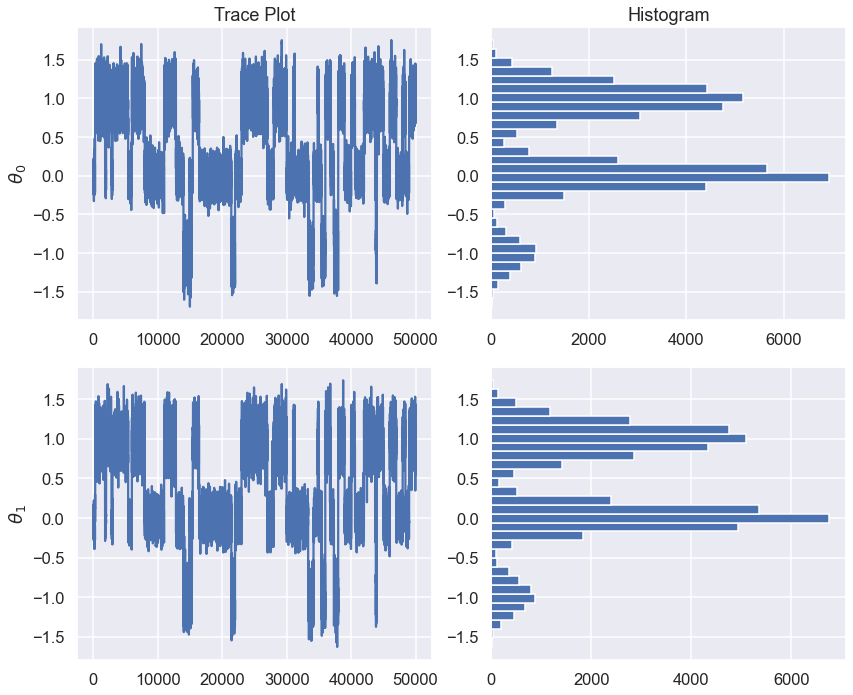

In [13]:
fix, ax = plt.subplots(2,2,figsize=(12,5*ndim))
for irow in range(ndim):
    ax[irow,0].plot(np.arange(samples.shape[0]),samples[:,irow])
    ax[irow,0].set_ylabel(r'$\theta_{0}$'.format(irow))
    ax[irow,1].hist(samples[:,irow],orientation='horizontal',bins=30)

ax[0,1].set_title('Histogram')
ax[0,0].set_title('Trace Plot')

plt.tight_layout()

In [14]:
for irow in range(ndim):
    print(f"Standard Error of the Mean for theta_{irow}: {samples[:,irow].std()/np.sqrt(samples.shape[0]):.1e}")

Standard Error of the Mean for theta_0: 2.9e-03
Standard Error of the Mean for theta_1: 2.9e-03


### Check for between chain variations
Note how the initial positions of the different walks are chosen here. What does `(-1)**chain` accomplish?

In [15]:
no_of_chains = 2
chains = []

for ichain in range(no_of_chains):
    sampler.reset()
    p0 = np.random.rand(nwalkers, ndim)/10 + (-1)**ichain
    # Warm-up
    if nwarmup > 0:
        print(f'Chain {ichain} performing {nwarmup} warmup iterations.')
        pos, prob, state = sampler.run_mcmc(p0, nwarmup)
        sampler.reset()
    else:
        pos = p0
    
    # Perform iterations, starting at the final position from the warmup.
    print(f'MH sampler {ichain} performing {nsteps} samples.')
    sampler.run_mcmc(pos, nsteps)
    print("done")
    print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

    chains.append(sampler.flatchain)

Chain 0 performing 1000 warmup iterations.
MH sampler 0 performing 1000 samples.
done
Mean acceptance fraction: 0.473
Chain 1 performing 1000 warmup iterations.
MH sampler 1 performing 1000 samples.
done
Mean acceptance fraction: 0.439


In [16]:
chain1 = chains[0]
chain2 = chains[1]

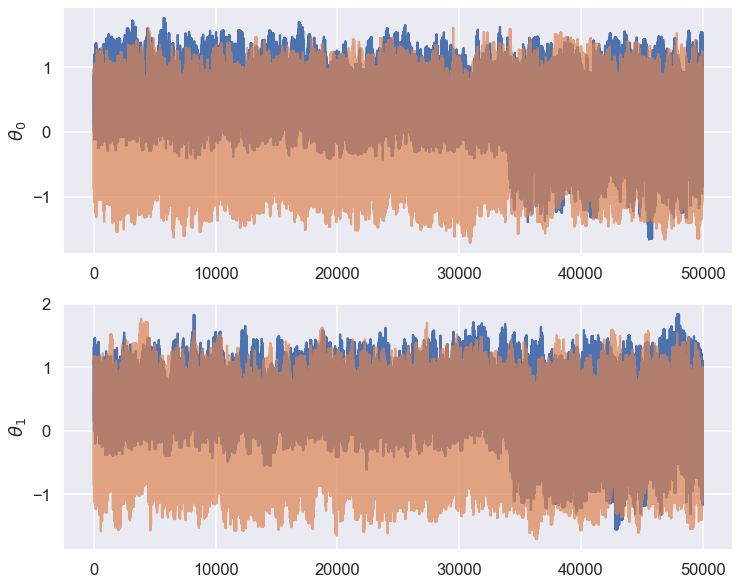

In [17]:
fix, ax = plt.subplots(2,1,figsize=(12,10))
for icol in range(ndim):
    ax[icol].plot(np.arange(chain1.shape[0]),chain1[:,icol])
    ax[icol].plot(np.arange(chain2.shape[0]),chain2[:,icol],alpha=.7)
    ax[icol].set_ylabel(r'$\theta_{0}$'.format(icol))

**Question:** *What do you conclude from the trace plots?* 

Let's plot it! (Note how the `posterior` function is used here.)

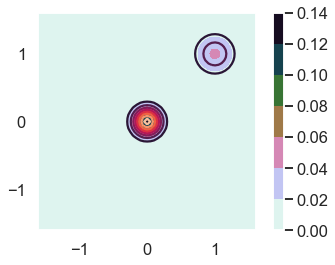

In [18]:
fig = plt.figure()
ax = fig.gca()

# Make data.
X = np.arange(-4, 4, 0.05)
Y = np.arange(-4, 4, 0.05)
X, Y = np.meshgrid(X, Y)
Z = posterior(Y,X)

ax.set_xlim([-1.6,1.6])
ax.set_ylim([-1.6,1.6])
ax.contour(X, Y, Z, 10)
CS = ax.contourf(X, Y, Z, cmap=plt.cm.cubehelix_r);
cbar = plt.colorbar(CS)
ax.set_aspect('equal', 'box')

## PT Sampler

Now we repeat the sampling but with a parallel tempering MCMC (or PTMCMC) sampler. We use ptemcee.

Here we construct the sampler object that will drive the PTMCMC.
Originally the temperature ladder was 21 temperatures separated by factors of 2; this is commented out below. To improve the accuracy of the integration for an evidence calculation, more lower temperatures were added, i.e., a finer grid near $\beta = 1$.

The highest temperature will be $T=1024$, resulting in an effective 
$\sigma_T=32\sigma=3.2$, which is about the separation of our modes. 


In [19]:

#ntemps = 21
#temps = np.array([np.sqrt(2)**i for i in range(ntemps)])

# Modified temperature ladder to improve the integration for evidence calculation
# need more low temperatures, i.e. finer grid near beta=1
ntemps_lo = 8
ntemps_hi = 21
temps_lo = np.array([2**(i/8.) for i in range(ntemps_lo)])
temps_hi = np.array([np.sqrt(2)**i for i in range(ntemps_hi)])
temps = np.concatenate((temps_lo,temps_hi[temps_hi>max(temps_lo)]))
ntemps=len(temps)

# Let us use 10 walkers in the ensemble at each temperature:
nwalkers = 10
ndim = 2

nburnin = 1000
niterations=1000
nthin = 10 # only record every nthin iteration

nthreads = 1  # threading didn't work with current set up (revisit)

In [20]:
betas=1/temps   # define the beta grid

Use the ptemsee sampler.

In [21]:

sampler = ptemcee.Sampler(nwalkers, ndim, log_likelihood, log_prior, ntemps,
                         threads=nthreads, betas=betas)

#Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to Sampler. 

#First, we run the sampler for 1000 burn-in iterations:

# initial walkers are normally distributed with mean mup and standard deviation sigp.
p0 = np.random.normal(loc=mup, scale=sigp, size=(ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in sampler.sample(p0, iterations=nburnin):
    pass
sampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:

for p, lnprob, lnlike in sampler.sample(p,iterations=niterations, thin=nthin):
    pass 

Running burn-in phase
Running MCMC chains


In [23]:
# The resulting samples (nwalkers*niterations/nthin of them)
# are stored as the sampler.chain property:

assert sampler.chain.shape == (ntemps, nwalkers, niterations/nthin, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)
print(f"The zero temperature mean is: {mu0}")

(mu1,mu2,mu3,sigma1inv,sigma2inv,sigma3inv,norm1,norm2,norm3)=params_modes
print("To be compared with likelihood distribution: ")
print(f"... peak 1: {mu1}, peak 2: {mu2}")

The zero temperature mean is: [0.27939075 0.26821336]
To be compared with likelihood distribution: 
... peak 1: [1. 1.], peak 2: [-1. -1.]


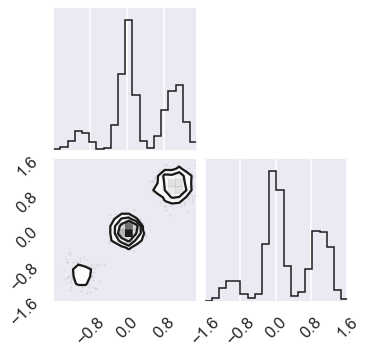

In [24]:
# Check the zero temperature corner plot
mcmc_data0 = sampler.chain[0,...].reshape(-1,ndim)
figure = corner.corner(mcmc_data0)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

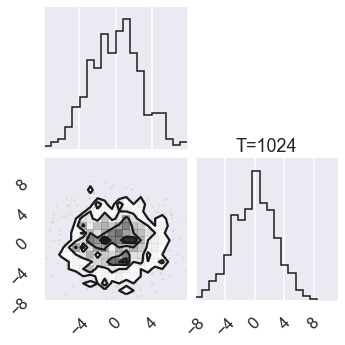

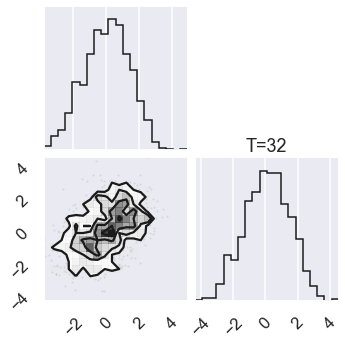

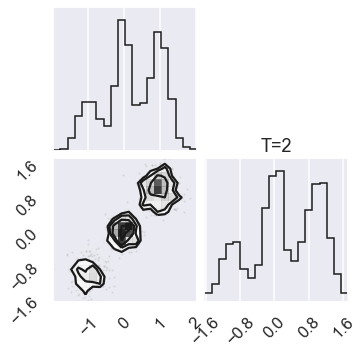

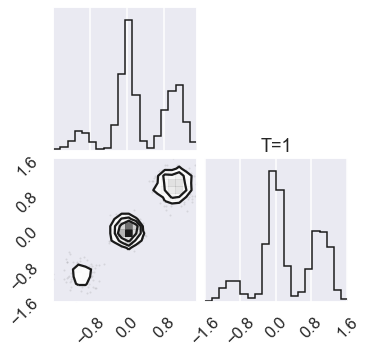

In [25]:
# Plot the posterior for four different temperatures
ntempered = np.array([ntemps-1,ntemps-11,8,0])

for nt in ntempered:
    mcmc_data_nt = sampler.chain[nt,...].reshape(-1,ndim)
    figure = corner.corner(mcmc_data_nt)
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    axes[ndim-1,ndim-1].set_title('T=%i' %temps[nt])